In [1]:
%matplotlib inline
# %matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
sys.path.insert(0, 'functions/')
from h5_tools import *
from fitting_tools import *

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from Xana import Xana
from glob import glob
import re
from lmfit.models import LinearModel
from pathlib import Path
from tqdm import tqdm
#plt.style.use('../nbstyle.mplstyle')
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.7"})

In [3]:
datadir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/'
anadir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed'
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

# Analysis database

In [108]:
# datafolder = 'ferritin_conc_gly_50_6' #
# datasetnumber = 4 # 230 K

# runnames = ['ferritin_conc_gly_50_6', 'ferritin_conc100_gly_50_1', 'ferritin_conc120_gly_50_1']
# datasetnumbers = [3,9,7] # 240 K

# 240 K
datafolder = 'ferritin_conc_gly_50_6'
datasetnumber = 3 

# datafolder = 'ferritin_conc100_gly_50_1'
# datasetnumber = 9

# datafolder = 'ferritin_conc120_gly_50_1'
# datasetnumber = 7

In [109]:
ana_db_files = glob(f'{anadir}/results/{datafolder}_{datasetnumber:04d}/p*/analysis_database.pkl')
# ana_db_files = glob(f'{anadir}/results/{datafolder}_{datasetnumber:04d}/p34*/analysis_database.pkl') # for c2
ana_db_files

['/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_6_0003/p338527/analysis_database.pkl',
 '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_6_0003/p338523/analysis_database.pkl',
 '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_6_0003/p338524/analysis_database.pkl',
 '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_6_0003/p338526/analysis_database.pkl',
 '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_6_0003/p338525/analysis_database.pkl',
 '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_6_0003/p338528/analysis_database.pkl']

In [110]:
d = Xana(fmtstr='ebs_id10_eiger500k', detector='eiger500k', setupfile=f'{anadir}/mask-setup/setup-fullmask-cryo-230417.pkl')
maskfile = d.setup.maskfile
d = Xana(fmtstr='ebs_id10_eiger500k', detector='eiger500k', setupfile=f'{anadir}/mask-setup/setup-fullmask-cryo-230417.pkl', maskfile=maskfile)

for i, f in enumerate(ana_db_files):
    if i == 0:
        d.load_db(f)
    else:
        d.append_db(f)

Loaded setupfile:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/mask-setup/setup-fullmask-cryo-230417.pkl.
Loaded setupfile:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/mask-setup/setup-fullmask-cryo-230417.pkl.
Try loading database:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_6_0003/p338527/analysis_database.pkl
Successfully loaded database


In [111]:
def get_scan_number(s):
    s = str(s)
    s = re.search('(?<=scan)\d{4}', s)
    if s is not None:
        return int(s.group(0))
    else:
        return -1
    
def get_rep(x, reps_per_spot=1):
    scan = get_scan_number(x)
    rep = scan % reps_per_spot
    if rep == 0:
        rep = 4
    return rep

In [112]:
d.db['rep'] = d.db['master'].apply(lambda x: get_rep(x, reps_per_spot=4))
d.db['scannumber'] = d.db['datdir'].apply(lambda x: get_scan_number(str(x)))

In [113]:
rep = 1
ind_xpcs = d.db[(d.db['analysis'] == 'xpcs')
                & (d.db['rep'] == rep)].index.values
print(f"number of xpcs analysis: {len(ind_xpcs)}")
d.db.loc[ind_xpcs]

number of xpcs analysis: 111


,use,sample,analysis,mod,savname,savfile,setupfile,comment,series,t_exposure,t_readout,nframes,master,first,last,datdir,rep,scannumber
7,True,,xpcs,2023-06-21 13:29:35.477640,s0229_0007.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,229.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,1,229
15,True,,xpcs,2023-06-21 13:40:11.964610,s0233_0015.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,233.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,1,233
23,True,,xpcs,2023-06-21 13:50:46.656005,s0237_0023.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,237.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,1,237
31,True,,xpcs,2023-06-21 14:01:21.840505,s0241_0031.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,241.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,1,241
39,True,,xpcs,2023-06-21 14:11:54.249433,s0245_0039.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,245.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,1,245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,True,,xpcs,2023-06-21 15:48:03.956630,s0357_0113.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,357.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,1,357
865,True,,xpcs,2023-06-21 15:58:30.465095,s0361_0121.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,361.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,1,361
873,True,,xpcs,2023-06-21 16:08:59.451736,s0365_0129.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,365.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,1,365
881,True,,xpcs,2023-06-21 16:19:26.082700,s0369_0137.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,369.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,1,369


# Compute $\chi_4$

In [114]:
def var(ttc):
        """Calculate the variance of the two-time correlation function.
        Args: ttc two-time correlation function (2d array)
        To normalize:
            chi4 = vartrc(ttc)
            chi4 /= np.average(ttc)**2
        """
        n, tmp = np.shape(ttc)
        ttc_var = []
        
        for off_diag in range(1, n-1):
            ttc_var.append(np.var(np.diag(ttc, off_diag)))
#         chi4 = ttc_var / np.average(ttc)**2

        return ttc_var

def var_norm(ttc):
        """Calculate the variance of the two-time correlation function.
        Args: ttc two-time correlation function (2d array)
        To normalize:
            chi4 = vartrc(ttc)
            chi4 /= np.average(ttc)**2
        """
        n, tmp = np.shape(ttc)
        ttc_var = []
        
        for i in range(1, n-1):
            ttc_var.append(np.var(np.diag(ttc, i)))
        chi4 = ttc_var / np.average(np.diag(ttc, k=0))**2

        return chi4

In [115]:
# %%timeit
chi4s1 = []
chi4s2 = []

time = d.get_item(ind_xpcs[0])['twotime_xy'][1:-1]

for i,ind in tqdm(enumerate(ind_xpcs[:]), desc='index', leave=False, total=len(ind_xpcs)):
    chi4s2.append(var_norm(list(d.get_item(ind)['twotime_corf'].values())[2]))
    chi4s1.append(var(list(d.get_item(ind)['twotime_corf'].values())[2]))

In [118]:
print(np.shape(chi4s2))
chi4_2, dchi4_2 = np.mean(chi4s2, axis=0), np.std(chi4s2, axis=0) / np.sqrt(len(chi4s1))
chi4_1, dchi4_1 = np.mean(chi4s1, axis=0), np.std(chi4s1, axis=0) / np.sqrt(len(chi4s1))

(111, 4988)


/tmp/ipykernel_32576/345830942.py:19: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  a1.set_xlim(0,1)
/tmp/ipykernel_32576/345830942.py:23: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  a2.set_xlim(0,1)


Text(0.5, 1.0, 'ferritin_conc_gly_50_6 3')

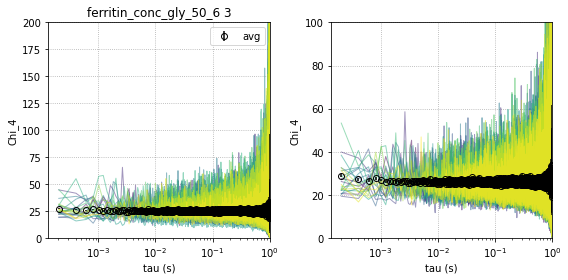

In [119]:
fig, (a1,a2) = plt.subplots(1,2, figsize=(8,4), tight_layout=True)
cs = plt.cm.viridis(np.linspace(0,1,len(chi4s2)))

for i in range(0,len(chi4s2),5):
    a1.plot(time, chi4s2[i], lw=1, c=cs[i], alpha=.5)
    a2.plot(time, chi4s1[i], lw=1, c=cs[i], alpha=.5)

# plt.plot(time, chi4, '-k', label='avg')
a1.errorbar(time, chi4_2, dchi4_2, c='k', marker='o', mfc='none', ls='', label='avg')
a2.errorbar(time, chi4_1, dchi4_1, c='k', marker='o', mfc='none', ls='', label='avg')

a1.set_xscale('log')
a2.set_xscale('log')
a1.legend()
a1.grid(ls=':', c='gray', alpha=0.7)
a1.set_xlabel('tau (s)')
a1.set_ylabel('Chi_4')
a1.set_ylim(0,200)
a1.set_xlim(0,1)
a2.set_xlabel('tau (s)')
a2.set_ylabel('Chi_4')
a2.set_ylim(0,100)
a2.set_xlim(0,1)
a1.set_title(f'{datafolder} {datasetnumber}')

### try log interpolation

In [120]:
import scipy as sp
import scipy.interpolate

def log_interp1d(xx, yy, kind='linear'):

    result = np.where(yy > 0.0000000001, yy, -10)
    logy = np.log10(result, out=result, where=result > 0)


    logx = np.log10(xx)
    # logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))

    return log_interp

/tmp/ipykernel_32576/4130415213.py:42: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  a1.set_xlim(0,1)
/tmp/ipykernel_32576/4130415213.py:46: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  a2.set_xlim(0,1)


Text(0.5, 1.0, 'ferritin_conc_gly_50_6 3')

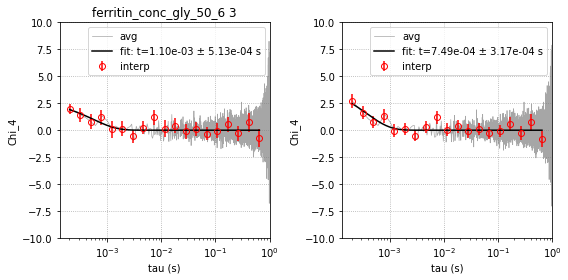

In [121]:
fig, (a1,a2) = plt.subplots(1,2, figsize=(8,4), tight_layout=True)
cs = plt.cm.viridis(np.linspace(0,1,len(chi4s2)))

new_x = np.logspace(np.log10(time[0]), np.log10(time[-1]), 20)
f = log_interp1d(time[:], chi4_2[:])
df = log_interp1d(time[:], dchi4_2[:])

base = np.mean(f(new_x)[-8:-1])
# a1.errorbar(time, chi4_2, dchi4_2, c='gray', ls='-', alpha=0.7,lw=0.7, label='avg')
a1.plot(time, chi4_2-base, c='gray', ls='-', alpha=0.7,lw=0.7, label='avg')
# a1.plot(new_x[:-1], f(new_x)[:-1], c='r', marker='o', mfc='none', ls='', label='interp')
a1.errorbar(new_x[:-1], f(new_x)[:-1]-base, df(new_x)[:-1],c='r', marker='o', mfc='none', ls='', label='interp')
# -- fit

popt,xc,curve,perr = fit(exponential, new_x[:-1], f(new_x)[:-1]-base, sigma= df(new_x)[:-1], p0=[2.5,5e-3], bounds=[(0,0),(np.infty,np.infty)])
a1.plot(xc, curve, ls='-', c='k', label=f'fit: t={popt[1]:.2e} ± {perr[1]:.2e} s')



f1 = log_interp1d(time[:], chi4_1[:])
df1 = log_interp1d(time[:], dchi4_1[:])
base1 = np.mean(f1(new_x)[-8:-1])
# a1.errorbar(time, chi4_1, dchi4_1, c='gray', ls='-', alpha=0.7,lw=0.7, label='avg')
a2.plot(time, chi4_1-base1, c='gray', ls='-', alpha=0.7,lw=0.7, label='avg')
# a1.plot(new_x[:-1], f(new_x)[:-1], c='r', marker='o', mfc='none', ls='', label='interp')
a2.errorbar(new_x[:-1], f1(new_x)[:-1]-base1, df1(new_x)[:-1],c='r', marker='o', mfc='none', ls='', label='interp')

popt,xc,curve,perr = fit(exponential, new_x[:-1], f1(new_x)[:-1]-base1, sigma= df1(new_x)[:-1], p0=[2.5,5e-3], bounds=[(0,0),(np.infty,np.infty)])
a2.plot(xc, curve, ls='-', c='k', label=f'fit: t={popt[1]:.2e} ± {perr[1]:.2e} s')

# a1.plot(new_x, np.zeros(len(new_x)), c='r', marker='x', mfc='none', ls='-', label='interp')
# a2.errorbar(time, chi4_1, dchi4_1, c='k', marker='o', mfc='none', ls='', label='avg')

a1.set_xscale('log')
a2.set_xscale('log')
a1.legend()
a2.legend()
a1.grid(ls=':', c='gray', alpha=0.7)
a1.set_xlabel('tau (s)')
a1.set_ylabel('Chi_4')
a1.set_ylim(-10,10)
a1.set_xlim(0,1)
a2.set_xlabel('tau (s)')
a2.set_ylabel('Chi_4')
a2.set_ylim(-10,10)
a2.set_xlim(0,1)
a1.set_title(f'{datafolder} {datasetnumber}')

In [123]:
save = False
if save:
    np.savez('../03-source/chi4_c1_240K', time=new_x[:-1], chi4=f(new_x)[:-1], dchi4=df(new_x)[:-1])

## compare concentrations

In [90]:
cs = ['c1', 'c2', 'c3']
times_240, chis_240, dchis_240 = [], [], []

for c in cs:
    f = np.load(f'../03-source/chi4_{c}_240K.npz')
    chis_240.append(f['chi4'])
    dchis_240.append(f['dchi4'])
    times_240.append(f['time'])

/tmp/ipykernel_32576/119960247.py:23: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  a1.set_xlim(0,1)


Text(0.5, 0, 'concentrations')

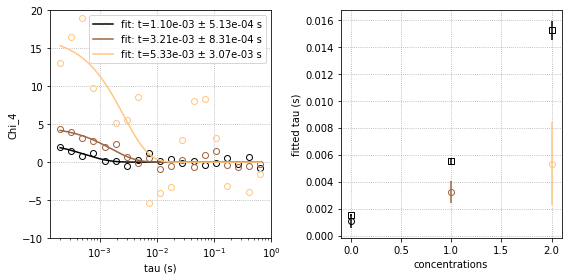

In [102]:
f, (a1,a2) = plt.subplots(1,2, figsize=(8,4), tight_layout=True)
col = plt.cm.copper(np.linspace(0,1,len(cs)))

taus_g2 = [1.54e-3, 5.5e-3, 15.23e-3]
dtaus_g2 = [0.07e-3, 0.2e-3, 0.7e-3]

for i in range(len(cs)):
    b = np.mean(chis_240[i][-7:])
    a1.plot(times_240[i], chis_240[i]-b,  marker='o', mfc='none', ls='', c=col[i])
    
    popt,xc,curve,perr = fit(exponential, times_240[i], chis_240[i]-b, sigma=dchis_240[i], p0=[2.5,5e-3], bounds=[(0,0),(np.infty,np.infty)])
    a1.plot(xc, curve, ls='-', c=col[i], label=f'fit: t={popt[1]:.2e} ± {perr[1]:.2e} s')

    a2.errorbar(i, popt[1], perr[1], ls='', marker='o', c=col[i], mfc='none')
    a2.errorbar(i, taus_g2[i], dtaus_g2[i], ls='', c='k', marker='s', mfc='none')

a1.grid(ls=':', c='gray', alpha=0.7)
a1.set_xlabel('tau (s)')
a1.set_ylabel('Chi_4')
a1.set_xscale('log')
a1.legend()
a1.set_ylim(-10,20)
a1.set_xlim(0,1)

a2.set_ylabel('fitted tau (s)')
a2.set_xlabel('concentrations')

# TTC

In [22]:
def load_ttc(filename, qpar=2, rep=0, vs=(0,0.15), ttc_key='/xpcs/ttcs/ttc_rep_qs_avg_filtered'):
    """ Load average twotime correlation function for different a given momentum transfer """
    ttc_qv = load_data(filename, '/xpcs/ttcs/q')
    # ttc_pars = load_data(filename, '/xpcs/ttcs/twotime_par')
    time = load_data(filename, '/xpcs/ttcs/times')

    qv = d.get_item(ind_xpcs[0])['qv'][qpar]

    with h5py.File(filename, 'r') as f:
        ttc = np.asarray(f[ttc_key][qpar])[rep,:,:]
    
    return ttc, qv

In [23]:
qpar = 2
qv = d.get_item(ind_xpcs[0])['qv'][qpar]
ttc_1 = d.get_item(ind_xpcs[0])['twotime_corf'][qpar]

In [24]:
filename = h5dir + f'{datafolder}_{datasetnumber:04d}.h5'
ttc, qv_ttc = load_ttc(filename)#, qpar=2, rep=0, vs=(0,0.15), ttc_key='/xpcs/ttcs/ttc_rep_qs_avg_filtered')

/tmp/ipykernel_32576/508662769.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(shrink=.8)


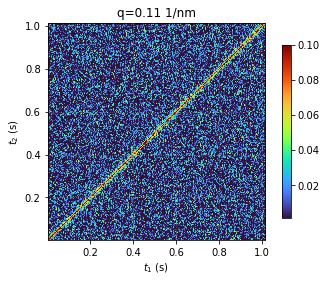

In [30]:
plt.figure()
norm = np.mean(ttc[:300,-300:])
plt.imshow(ttc-norm, cmap='turbo', extent=(time[0], time[-1])*2, origin='lower', vmax=1e-1, vmin=1e-3)
plt.xlabel('$t_1$ (s)')
plt.ylabel('$t_2$ (s)')
plt.title(f'q={qv:.2f} 1/nm')
plt.colorbar(shrink=.8)

/tmp/ipykernel_32576/1704467438.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(shrink=.8)


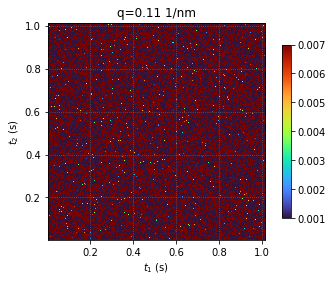

In [29]:
plt.figure()
norm = np.mean(ttc_1[:300,-300:])
plt.imshow(ttc_1-norm, cmap='turbo', extent=(time[0], time[-1])*2, origin='lower', vmax=7e-3, vmin=1e-3)

plt.xlabel('$t_1$ (s)')
plt.ylabel('$t_2$ (s)')
plt.title(f'q={qv:.2f} 1/nm')
plt.colorbar(shrink=.8)

In [ ]:

    
# for i in range(0,len(ttc_qv)):
#     ax = axs.ravel()[i]
#     norm = np.mean(ttcs[i,:300,-300:])


def plot_ttc(filename, rep=0, vs=(0,0.15), ttc_key='/xpcs/ttcs/ttc_rep_qs_avg_filtered'):
    """Plots the twotime correlation function for different momentum transfers"""
    ttc_qv = load_data(filename, '/xpcs/ttcs/q')
    # ttc_pars = load_data(filename, '/xpcs/ttcs/twotime_par')
    time = load_data(filename, '/xpcs/ttcs/times')
    
    ttcs = np.empty(shape=(len(ttc_qv), len(time), len(time)))
    with h5py.File(filename, 'r') as f:
        ttcs = np.asarray(f[ttc_key])[rep,:,:,:]
        
    # f, axs = plt.subplots(2,3,figsize=(10,6), tight_layout=True)
    f, axs = plt.subplots(2,5,figsize=(15,6), tight_layout=True)
    for i in range(0,len(ttc_qv)):
        ax = axs.ravel()[i]
        norm = np.mean(ttcs[i,:300,-300:])
        # vmax = np.mean(np.diag(ttcs[i,:,:],k=10))

        ax.imshow(ttcs[i,:,:]-norm, origin='lower', cmap='turbo', vmin=vs[0], vmax=vs[1], extent=(time[0],time[-1])*2 )
        ax.set_xlabel('$t_1 (s)$')
        ax.set_title(f'{ttc_qv[i]:.2f} 1/nm', fontsize=8)
        ax.set_ylabel('$t_2 (s)$')
        divider = make_axes_locatable(ax)
        cb1 = mpl.colorbar.ColorbarBase(divider.append_axes('right', size='5%', pad=0.05), cmap=mpl.cm.turbo,  orientation='vertical', norm=mpl.colors.Normalize(vmin=vs[0],vmax=vs[1]));


# Functions

In [ ]:
def vartrc(ttc):
        """Calculate the variance of the two-time correlation function.
        Args: ttc tto-time correlation function (2d array)
        To normalize:
            chi4 = vartrc(ttc)
            chi4 /= np.average(ttc)**2
        """
        n, tmp = np.shape(ttc)
        ttc_var = []
        
        for i in range(1, n-1):
            ttc_var.append(np.var(np.diag(ttc, i)))
#         chi4 = ttc_var / np.average(ttc)**2

        return ttc_var